In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale, StandardScaler
from pylab import rcParams
import scipy.cluster.hierarchy as sch

### Define two functions for cluster analysis visualisation

In [20]:
def pd_centers(featuresUsed, centers):
    from itertools import cycle, islice
    from pandas.plotting import parallel_coordinates
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

def parallel_plot(data):
    from itertools import cycle, islice
    from pandas.plotting import parallel_coordinates
    import matplotlib.pyplot as plt

    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([1,5])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')
    plt.xticks(rotation=75)

## **1. Prepare the dataset**

In [3]:
responses = pd.read_csv("responses.csv")

responses.at[676,'Height'] += 100 # repair value

### Divide dataset onto severall parts

In [4]:
music = responses.loc[:,'Dance':'Opera']
movies = responses.loc[:,'Horror':'Action']
hobbies = responses.loc[:,'History':'Pets']
phobias = responses.loc[:,'Flying':'Fear of public speaking']
personality = responses.loc[:,'Daily events':'Spending on healthy eating'].select_dtypes(include=['int','float'])

### **Define 'braveness'**
Negation of 'breaveness' is a sum of individual's ratings of all fobias.

*Note: highter value = more brave.*

Text(0, 0.5, 'Density')

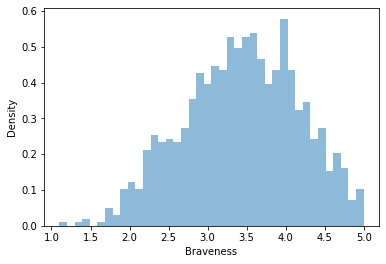

In [5]:
braveness = (50-phobias.sum(axis=1)) / 10 + 1
braveness.plot.hist(bins=40, alpha=0.5, density = True)

responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)

plt.xlabel('Braveness')
plt.ylabel('Density')

### **Filter responses leaving only numerical values**

In [6]:
responses_int = responses_.select_dtypes(include=['int','float'])
print(responses_.shape, responses_int.shape)

(1010, 151) (1010, 140)


## **2. Search for correlations**

### ** 2.1. Divide data set onto male/female slice**

In [7]:
responses_int_filtered = responses_int[responses['Gender'] == 'female']
responses_male = responses_int[responses['Gender'] == 'male']
responses_female = responses_int[responses['Gender'] == 'female']

### 2.2. Generate plot of correlations of all features with a chosen `FEATURE`
Consider `men` and `women` datasets together.

Features correlated with 'Number of friends':


,Feature's name,Coefficient
61,Fun with friends,0.369
98,Loneliness,-0.287
105,Number of friends,1.000
110,Socializing,0.323
120,Happiness in life,0.299
121,Energy levels,0.367
123,Personality,0.275
126,Interests or hobbies,0.372


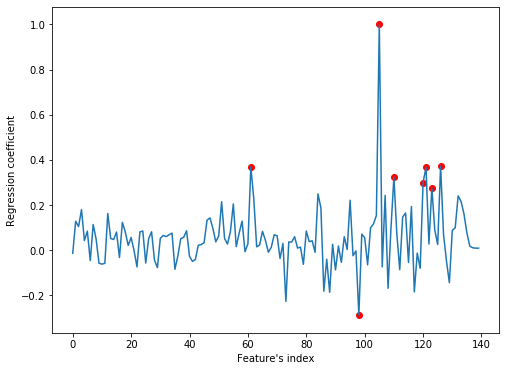

In [8]:
#FEATURE = 'Loneliness'
FEATURE = 'Number of friends'


rcParams['figure.figsize'] = 8,6

cols = responses_int_filtered.columns.to_list()

correlations = [responses_int_filtered[FEATURE].corr(responses_int_filtered[f]) for f in cols]


df = pd.DataFrame(correlations, columns = ['Correlations'])
df = df[abs(df['Correlations']) > 0.25]

corr_features = [cols[f] for f in df.index]

corr = responses_int_filtered[corr_features].corr().loc[:,FEATURE]#.drop([FEATURE])
print("Features correlated with '{}':".format(FEATURE))
corr_ = {'Feature\'s name':corr.index, 'Coefficient':round(corr,3).to_list()}
corr_ = pd.DataFrame(corr_, index = df.index)
display(corr_)


plt.plot(correlations)
plt.xlabel('Feature\'s index')
plt.ylabel('Regression coefficient')
plt.scatter(df.index, np.array(corr), c='r')
plt.show()

Red dots correspond to features correlated with `FEATURE`.

### 2.3. Search for interesting correlations
Consider `men` and `women` independently.

Find what features have most correlations with any of 'personality' features.
Find features that lead to correlations with similar Pearson's value for *both men and women treated separently*. This approach is crucial, because i.e. if `men` are more likely to be interested in `cars` than `women` and at the same time `men` are statisticaly `heigher` that `women`, then without considering gender independence we would get a correlation between `cars` and `height`, which is a nonsense.

In [9]:
# Index _1 stands for men, index_2 stands for women

for FEATURE in personality.columns:

    cols = responses_int_filtered.columns.to_list()

    correlations_1 = [responses_male[FEATURE].corr(responses_male[f]) for f in cols ]
    correlations_2 = [responses_female[FEATURE].corr(responses_female[f]) for f in cols ]


    df_1 = pd.DataFrame(correlations_1, columns = ['Correlations'])
    df_1 = df_1[ abs(df_1['Correlations']) > 0.25]
    df_2 = pd.DataFrame(correlations_2, columns = ['Correlations'])
    df_2 = df_2[ abs(df_2['Correlations']) > 0.25]


    corr_features_1 = [cols[f] for f in df_1.index]
    corr_features_2 = [cols[f] for f in df_2.index]


    corr_1 = responses_male[corr_features_1].corr().loc[:,FEATURE].drop([FEATURE])
    corr_2 = responses_female[corr_features_2].corr().loc[:,FEATURE].drop([FEATURE])

    # Find set of features  lead to correlations in both genders
    set_ = set(corr_1.index) & set(corr_2.index)
    
    
    # If at least 5 distinct correlation are found
    if len(corr_1) > 0 and len(set_) > 5:
        
        corr_ = {'Correlated feature\'s name':list(set_)
                 , 'Coefficient for Men':round(corr_1,3).loc[set_].tolist()
                 , 'Coefficient for Women':round(corr_2,3).loc[set_].tolist()}
        
        corr_ = pd.DataFrame(corr_)
        corr_ = corr_.style.set_caption("Feature\'s name: {}".format(FEATURE)).hide_index()
        display(corr_)

Correlated feature's name,Coefficient for Men,Coefficient for Women
Interests or hobbies,0.382,0.372
Energy levels,0.427,0.367
Loneliness,-0.345,-0.287
Fun with friends,0.345,0.369
Personality,0.273,0.275
Happiness in life,0.336,0.299
Socializing,0.35,0.323


Correlated feature's name,Coefficient for Men,Coefficient for Women
Active sport,0.319,0.322
Interests or hobbies,0.493,0.392
Loneliness,-0.336,-0.355
Fear of public speaking,-0.281,-0.256
Personality,0.33,0.325
Happiness in life,0.448,0.433
New environment,0.325,0.364
Number of friends,0.427,0.367
Socializing,0.365,0.303


Correlated feature's name,Coefficient for Men,Coefficient for Women
Knowing the right people,0.327,0.287
Spending on gadgets,0.354,0.41
Entertainment spending,0.385,0.47
Appearence and gestures,0.352,0.406
Shopping centres,0.478,0.483
Celebrities,0.267,0.278
Branded clothing,0.482,0.422
Shopping,0.455,0.544


## 3. Clustering

### 3.1. Perform Hierarchical clustering for a chosen `FEATURE`

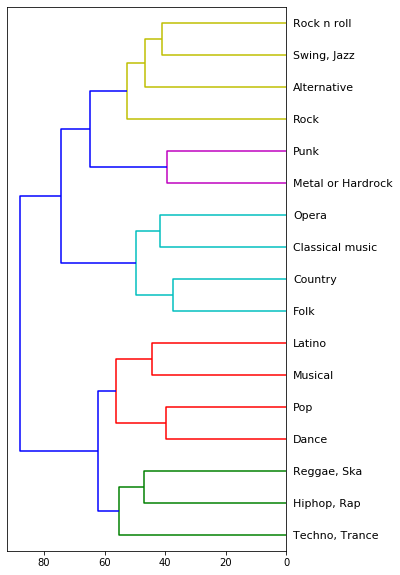

In [10]:
FEATURE = music  # [music, hobbies, phobias, personality]

df_select = FEATURE.copy(deep=True).dropna()
x = df_select.to_numpy().T
#
# Adjust figure size to accommodate the full tree
#
rcParams['figure.figsize'] = 5, 10
#
# Do hierarchical clustering using Ward's method
#
z = sch.linkage(x, method='ward')
#
# Display dendrogram
#
names = df_select.columns.tolist()
info = sch.dendrogram(z, orientation='left', labels=names, leaf_font_size=11)

**Comment 1: there seem to be 3 kinds of correlated fobias:**
- animals (Rats, Snakes, Dangerous dogs, Spiders)
- nature (Darkness, Storm, Flying)
- social (Fear of public speaking, Heights, Ageing)

**Comment 2: music clusters in 5 similar types:**
- **old music**: rock n roll, jazz, alternative
- **metal-like music**: rock**, punk, metal
- **instrumental music**": opera, classical, country, folk
- **popular music**: latino, musical, pop, dance
- **rap-like music**: reggae, hiphip, techno

** although rock was assigned to 'yellow label', it's not too far from 'magenta label', which seems more logical

### 3.2. Perform K-means clustering for people, basing on their phobias

In [13]:
# Generate a new dataframe by selecting the features you just defined

df_select = phobias.copy(deep=True).dropna()

# Perform scaling on the dataframe containing the features

#data = scale(df_select)
scaler_x = StandardScaler()
data = scaler_x.fit_transform(df_select)


sse = {}
for k in range(1,11):
    model = KMeans(init='k-means++', n_clusters=k, n_init=20).fit(data)
    sse[k] = model.inertia_

### 3.2.1) Elbow method

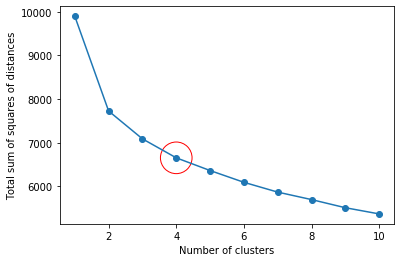

In [14]:
rcParams['figure.figsize'] = 6,4

plt.plot(list(sse.keys()), list(sse.values()), 'o', linestyle = '-')
plt.scatter( [4],[sse[4]], s = 1000, c = 'none', edgecolor = 'red')
plt.xlabel('Number of clusters')
plt.ylabel('Total sum of squares of distances')

# Define number of clusters

noOfClusters = 4

model = KMeans(init='k-means++', n_clusters=noOfClusters, n_init=20).fit(data)

In [15]:
print(90*'_')
print("\nCount of people in each cluster")
print(90*'_')

pd.value_counts(model.labels_, sort=False)

__________________________________________________________________________________________

Count of people in each cluster
__________________________________________________________________________________________


0    247
1    258
2    203
3    282
dtype: int64

### 3.2.2. Plot centers of individual clusters

In [23]:
P = pd_centers(featuresUsed=phobias.columns.to_list(), centers=scaler_x.inverse_transform(model.cluster_centers_))
P

,Flying,Storm,Darkness,Heights,Spiders,Snakes,Rats,Ageing,Dangerous dogs,Fear of public speaking,prediction
0,2.206478,1.639676,2.340081,3.085020,2.591093,2.307692,1.663968,2.684211,2.696356,3.392713,0
1,1.806202,1.720930,2.000000,2.313953,3.503876,4.073643,3.325581,2.895349,3.635659,2.701550,1
2,3.004926,3.527094,3.635468,3.586207,3.748768,4.187192,3.586207,3.211823,3.995074,3.280788,2
3,1.443262,1.358156,1.386525,1.751773,1.751773,1.875887,1.368794,1.726950,2.109929,2.049645,3


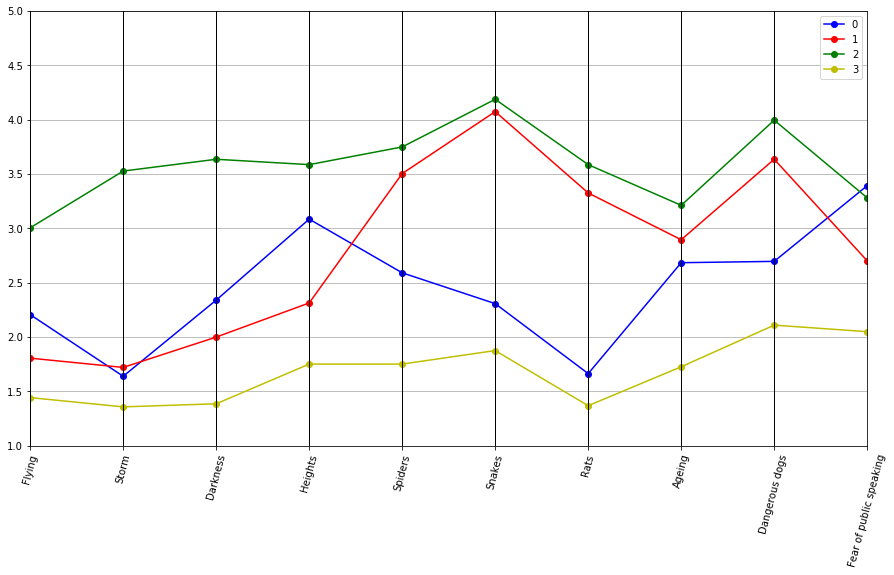

In [25]:
parallel_plot(P)

**Interpretation** (valid for 4 clusters). People seem to divide in 4 different types, according to phobias (ordered from the bottom at the label `Flying`):

- people scared of nothing.
- people scared of various animals.
- people scared of everything except of animals.
- people scared of everything.

### 3.2.3. Find outliners

Number of survey responser and its distance from nearest cluster:

458 	 4.619143943170529
516 	 4.675209057994655
614 	 4.778258533740639
989 	 4.486542738436116

All non-numeric informations about surveyors detected as outliers:


,Alcohol,Left - right handed,Punctuality,Smoking,Education,Lying,House - block of flats,Gender,Internet usage,Village - town,Only child
458,social drinker,right handed,i am often running late,tried smoking,secondary school,only to avoid hurting someone,house/bungalow,female,few hours a day,village,no
516,never,right handed,i am always on time,tried smoking,secondary school,sometimes,block of flats,male,few hours a day,city,no
614,social drinker,right handed,i am often early,current smoker,secondary school,sometimes,house/bungalow,female,few hours a day,village,no
989,drink a lot,right handed,i am often early,former smoker,masters degree,sometimes,house/bungalow,female,most of the day,village,no


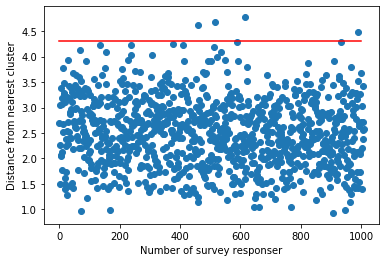

In [26]:
centers = model.cluster_centers_

# Maximum allowed distance from nearest cluster to not be considered as an outliner
    
RANGE = 4.3

# Plot distance from nearest cluster for all points for which cluster analysis was conducted
#
x = df_select.index.tolist()
y = [min([np.linalg.norm(a-b) for a in centers]) for b in data[:] ]
plt.scatter(x,y)
plt.plot([0,1000], [RANGE,RANGE], 'red') # above this line are outliners
plt.xlabel("Number of survey responser")
plt.ylabel("Distance from nearest cluster")


# Find which points are far away from any cluster. Print their indexies and measured distances
#
print( "Number of survey responser and its distance from nearest cluster:\n")
for i in range( 0, len(y)):
    if y[i] > RANGE:
        print (x[i],'\t',y[i])


# Select indexies of these points
#
outliners = [ i > RANGE for i in y]
outliners = df_select[ outliners]


# Find all informations about people who seem to be outliners
#
filter_ = np.full( responses.shape[0], False)
for i in range( 0, outliners.shape[0]):
    filter_[ outliners.index[i]] = True
    
    
print( "\nAll non-numeric informations about surveyors detected as outliers:")
df_ = responses[ filter_]
   
# Select columns including only strings

df_cols = set(df_.columns) - set(df_.select_dtypes(include=['int','float']).columns)
df_[df_cols]

**Comment:** Seems like almost all of the outliners are woman.

## 4. Histogram analysis of `non-numerical` features
This corresponds to features like `gender` or `left/right handling`.
### 4.1. Perform BMI (body mass index) distribution analysis within genders

In [27]:
bmi = responses['Weight'] / (responses['Height'] / 100)**2

responses_ = responses.copy()
responses_.insert(0, "Braveness", braveness.to_list(), True)
responses_.insert(0, "BMI", bmi.to_list(), True)


left_ = responses_[responses_['Left - right handed'] == 'left handed']
right_ = responses_[responses_['Left - right handed'] == 'right handed']

male_ = responses_[responses_['Gender'] == 'male']
female_ = responses_[responses_['Gender'] == 'female']

Text(0, 0.5, 'Density')

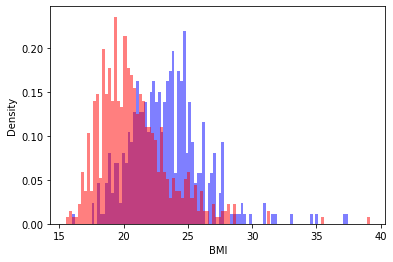

In [28]:
male_['BMI'].plot.hist(bins=100, alpha=0.5, color = 'blue', density = True)
female_['BMI'].plot.hist(bins=100, alpha=0.5, color = 'red', density = True)

rcParams['figure.figsize'] = 6,4
plt.xlabel('BMI')
plt.ylabel('Density')

**Interpretation:** both genders have gaussian-like distribution of BMI values, however their mean values differ:
- women's average BMI is around 20
- men's average BMI is around 24

### 4.2. Compare woman's and man's faith (religious aspect)

Men's fraction distribution:


5.0    0.255474
1.0    0.236010
3.0    0.214112
4.0    0.160584
2.0    0.133820
Name: God, dtype: float64

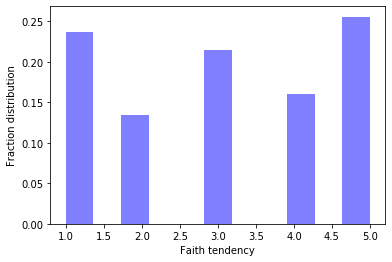

In [29]:
n = sum(male_['God'] == male_['God'])  # Disclude nan values in this feature's column

male_['God'].plot.hist(bins=11, alpha=0.5, color = 'blue', weights = [1./n for i in range(0,n)])
plt.xlabel('Faith tendency')
plt.ylabel('Fraction distribution')

print("Men's fraction distribution:")
male_['God'].value_counts(normalize=True)

Women's fraction distribution:


5.0    0.358714
3.0    0.211506
4.0    0.165821
1.0    0.152284
2.0    0.111675
Name: God, dtype: float64

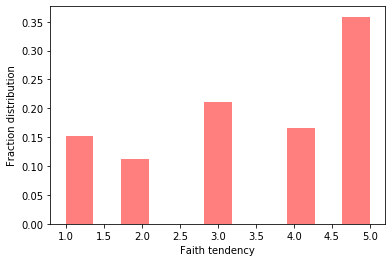

In [30]:
n = sum(female_['God'] == female_['God'])  # Disclude nan values in this column

female_['God'].plot.hist(bins=11, alpha=0.5, color = 'red', weights = [1./n for i in range(0,n)])
plt.xlabel('Faith tendency')
plt.ylabel('Fraction distribution')

print("Women's fraction distribution:")
female_['God'].value_counts(normalize=True)

**Interpretation:** woman are more likely to be religious.
- 36% of woman and 25% of men are strongly religious (5.0 points in survey).
- 15% of woman and 24% of men are atheist-like (1.0 point in survey).

## 5. Principal Component analysis (PCA)

### 5.1. Calculate covarriance matrix and its eigenvectors aswell as eigenvalues

In [31]:
# Select what slice of responders table you want to analyse
# Choose TYPE from [music, hobbies, movies, phobias, personality]

TYPE = movies
N = 4

df = TYPE.dropna()
df_np = np.array(df)

# Calculate covarriance matrix for all features (columns) in TYPE

Sigma = np.cov(df_np, rowvar=0, bias=1)

# Calculate eigenvectors of covarriance matrix

eigenvalues, eigenvectors = np.linalg.eigh(Sigma)

### 5.2. Print fraction of total variance considered when taking into account only `N` biggest eigenvectors in terms of eigenvalues

In [32]:
print(sum(eigenvalues[-N:]) / sum(eigenvalues))

0.6444598855259794


In [33]:
# Select N eigenvectors coresponding to N highest eigenvalues

U = eigenvectors[:,-N:]

# Reverse the order so the first column corresponds to highest eigeinvalue

U = U[:,::-1]


# Products of selected eigenvectors for each survey responder

rows = [(U.T).dot(row) for row in df_np]

# Columns' names

cols = [chr(i) for i in range(97,97+N)]

# Create a DataFrame containing `rows`, indexed like initial table after dropping NaNs

Big_Five = pd.DataFrame(rows, columns = cols, index = df.index.tolist())

# Add N new features as new columns to initial slice of responders table

Big_Five = pd.concat([df,Big_Five], axis=1) 

### 5.3. Correlate `N` new variables with rest of the features

In [34]:
corr_ = Big_Five.corr().loc[df.columns,cols]
corr_.style.background_gradient(cmap='coolwarm', low=0., high=0.3)

,a,b,c,d
Horror,-0.535215,0.0309583,0.749917,-0.179415
Thriller,-0.615426,-0.000449066,0.476329,-0.0734495
Comedy,0.0444655,-0.312498,0.204003,0.199404
Romantic,0.439811,-0.434911,0.173296,0.219201
Sci-fi,-0.603357,-0.25423,-0.0919016,0.575887
War,-0.658157,-0.126221,-0.348062,-0.358375
Fantasy/Fairy tales,0.255661,-0.842517,0.0987103,-0.114085
Animated,0.135865,-0.845927,0.148742,-0.113219
Documentary,-0.248598,-0.331022,-0.402476,-0.352805
Western,-0.543502,-0.172327,-0.3606,-0.0965979


### Comment 1.
If `TYPE` = `music`, then 5 most frequent chronotypes (involving 62% of all responders) correspond to following interpretation:

- `a` - likes very much **rock/metal/jazz**, hates **rap/techno/pop**
- `b` - likes very much **dance/musical/pop/latino**, hates very much **metal/punk**
- `c` - likes very much **hiphop/rap/reggae/punk/techno**, hates very much **classical/musical/opera**
- `d` - likes **all kinds** of music, hates very much **techno**
- `e` - likes **pop/rock/metal**, hates **reggae/jazz/alternative**

notice that `a` chronotype is the most common

**What simplifices to:**

- `a` - true metalhead
- `b` - pop music lover
- `c` - rapper
- `d` - all kinds of music person
- `e` - somehow like metalhead, but also likes pop


### Comment 2.
If `TYPE` = `hobbies`, then 6 most frequent chronotypes (involving 48% of all responders) correspond to following interpretation:

- `a` - hates essentialy everything
- `b` - likes very much **mathematics/phisics/PC/cars/science/adrenaline sports**, hates **reading**
- `c` - likes very much **biology/chemistry/medicine**, hates very much **politics/economy/law**
- `d` - likes **mathematics/phisics/history/religion**, hates very much **celebrities/shopping/pets**
- `e` - likes very much **instruments**, hates **law/economy/politics**
- `f` - likes **history/geography**, hates **mathematics**

**What translates to following chronotypes:**

- `a` - lazy person
- `b` - science person who adores activities
- `c` - medician
- `d` - science person who hates activities
- `e` - musician
- `f` - humanist

### Comment 3.
If `TYPE` = `movies`, then 4 most frequent (involving 64% of all responders) movie preferences are following:

- `a` - romantic films (mostly women)
- `b` - essentialy nothing
- `c` - horror and thriller
- `d` - science fiction and action